## Introduction / Overview
[Choropleth Maps](https://en.wikipedia.org/wiki/Choropleth_map) have become very familiar to us. They are commonly used to visualize information such as [Covid-19 infection/death rates](https://coronavirus.jhu.edu/us-map), [education spending per pupil](https://www.reddit.com/r/MapPorn/comments/bc9jwu/us_education_spending_map/), and other similar data.

Visualizing data in this way can reveal patterns that might otherwise be hard to discern; one might be able to understand some of this from tables of figures, but the spacial aspect might be overlooked. Thus, this type of map can be very useful to historians and other scholars.

This lesson will demonstrate how the Folium library can be used to create choropleth maps quickly and easily. However, while a basic map is easy to create, they often require some adjustments to be as informative as possible. The level of complexity will increase as we move through the lesson. In an appendix, I included a discussion of how to normalize data (how to calculate "X per 100K population"); for many choropleth maps, this is an important step.

At the end of the lesson you will be able to:
* Load several types of data from web archives
* How to associate latitude/longitude points with county names, geography, and FIPS numbers
* Create a basic choropleth map
* Reflect on some issues that map-designers need to consider, especially the problem of dealing with non-normal distributions of data
* Enhance a Folium map with titles, popup data, and mini-maps.
* One issue with choropleth maps that display data about people is that this data tends to correlate closely with population centers; in the appendix, I will show how this issue can be addressed.

We will be exploring the *Washington Post*'s [Fatal Force](https://github.com/washingtonpost/data-police-shootings) database. Starting in 2015, the *Post* started the database, which seeks to document every time an encounter with a police officer ends in the death of the civilian. This data isn't collected or reported systematically, so the *Post*'s work fills an important lacuna in our understand of how police interact with the people around them.

My comments will reflect the data in the database as of April, 2023. Tragically, I can confidently predict that these numbers will continue to increase; when I write that 2023 has the lowest number of fatal encounters between police and civilians, it only reflects the situation in the first five months of the year.

## Folium
To create the maps, we will use Folium. [Folium](https://python-visualization.github.io/folium/) is a Python library that automates creating Leaflet maps.

[Leaflet](https://leafletjs.com/) is a JavaScript library that faciliates the creation of interactive HTML maps. To use Leaflet one needs to know some CSS and JavaScript, as Kim Pham describes in his Programming Historian article ["Web Mapping with Python and Leaflet"](https://programminghistorian.org/en/lessons/mapping-with-python-leaflet).

Folium makes it *much* easier to create Leaflet maps. For basic maps, the user doesn't need to work with HTML, CSS, or JavaScript: everything can be done within the Python ecosystem.

Folium's basic maps (putting pins / circles of various sizes and colors, cluster maps, and heat) on a map are very easy; this lesson will explore more advanced features: overlaying a map with a cloropleth map.

## Python, Pandas, and Geopandas
Python is the most popular programming language ([1](https://www.zdnet.com/article/programming-languages-python-just-took-a-big-jump-forward/), [2](https://www.infoworld.com/article/3669232/python-popularity-still-soaring.html)). It is especially useful for [data scientists](https://www.makeuseof.com/why-is-python-popular-for-data-science/) and others interested in analyzing data and visualizing data because it has an enormous library of tools specifically for these applications. This lesson assumes some proficency with Python, but I will explain things that might be unfamilar.

[Pandas](https://pandas.pydata.org/) is a powerful package for data manipulation, analysis, and visualization. This lesson assumes some proficency with Pandas, although when I do something interesting/confusing/advanced with it, I will explain what the system is doing.

There are several other Programming Historian lessons ([1](https://programminghistorian.org/en/lessons/visualizing-with-bokeh), [2](https://programminghistorian.org/en/lessons/crowdsourced-data-normalization-with-pandas)) that use Pandas. Pandas also includes a [Getting started](https://pandas.pydata.org/docs/getting_started/index.html) tutorial.

Pandas has two basic data strutures: the `series` and the `dataframe`(often abbreviated as *DF*.
* A dataframe is similar to a spreadsheet: it has rows and columns of data.
 * rows have index values (akin to the row numbers in a spreadsheet)
 * columns have column names (unlike a spreadsheet, which typically use letters for columns)

* A series is a single column in a dataframe (or in a spreadsheet).

[Geopandas](https://geopandas.org/en/stable/) is built on Pandas and adds extensions to make working with geospacial data easier. Notably, it adds some [shapely](https://shapely.readthedocs.io/en/stable/) datatypes to Pandas that include `point` and `geometry`.

## Colab
This lesson assumes that one is using Google's [Colab](https://colab.research.google.com/) system. Colab allows users to create [Jupyter notebook](https://realpython.com/jupyter-notebook-introduction/)-like files that combine markdown text and Python cells.

Colab is very useful in the classroom, since it runs entirely on the web. Students can access Colab notebooks with any computer or tablet that runs a modren web-browser. This means that instructors don't need to write different instructions for Macs, PCs, Linux, Chromebooks, etc. The system is fast and powerful: the virtual machines generally have around 12GB RAM and 23GB disk space; designed for machine learning, it also allows users to add a graphics card / hardware accelerator (we won't be using this!). Since computation is done in the cloud, users don't need to have a powerful machine to use the system.

Colab includes a very large collection of Python libraries, as it is intended for data science and machine learning. In our lesson, most of our libraries are all part of the standard Colab system. One exception is the `geopandas` library.

Colab allows users to install missing libraries with the `pip` command. As in other Jupyter systems, we can access the command line (bash) with an `!` mark.

Colab runs in the cloud. When we close the window, the Jupyter notebook will be saved, but unless data is saved to a users Google drive or to a local drive, it will disappear. This is also the case for libraries installed with `! pip`: they are available while the notebook executes, but need to be installed each time they are going to be accessed. (Unlike on a normal computer: when a library is installed with `pip`, it is saved to the drive and doesn't need to be reinstalled.)

Most of the libraries we will be using are part of Colab's default collection, but a couple are not. One of these is `geopandas`, so we will install it with the bash command `!pip install geopandas`.

> The Unix/Linux terminal shell (or command line) is called [bash](https://en.wikipedia.org/wiki/Bash_(Unix_shell)). iOS and Windows have similar terminal shell programs. Jupyter notebooks allow users to issue terminal commands by prefixing the command with an exclaimation point; Colab follows this convention.

In the next cell, we will install `geopandas`.

In [ ]:
pip install geopandas
pip install folium

## Import Libraries
After we install geopandas, we're ready to import the libraries we will be using for this lesson.

Note that the libraries are loaded and assigned the library's common alias (`pd` and `gpd`). As we call methods from the libraries, we will use these aliases instead of the full library name.

In [2]:
import pandas as pd
import geopandas as gpd
import folium

## Get the Data

### Fatal Force Data
Before importing the data, I read the *Post*'s [documentation](https://github.com/washingtonpost/data-police-shootings/tree/master/v2) about the datafields, so I know there is a `date` field.

Pandas tries to parse data as it imports it. It is pretty good at recognizing *string* (character) data and *numeric* data and imports them as `object` and `int64` or `float64` datatypes. But it struggles with date-time fields. If we include the keyword `parse_dates=` parameter, along with the name of the date column, Pandas will parse the date field and make it a `datetime64` datatype.

In [ ]:
ff_df = pd.read_csv('https://raw.githubusercontent.com/washingtonpost/data-police-shootings/master/v2/fatal-police-shootings-data.csv',
                    parse_dates = ['date'])

We will look at the fatal force dataframe (ff_df) to see what sort of data it has, to check the data types, and take a look at the sample data.

In [ ]:
ff_df.info()

In [ ]:
ff_df.sample(5)

As of April 26, 2023 there are 8,410 records in the database.

Most of our fields are `object` (which is what Pandas calls `string` or text) data. `date` is a `datetime` object. And there are numbers for the `latitude`,`longitude` and `age` fields.

If the lat/lon fields were not numbers, we would need to do some data cleaning to get them convered to `float`-type numbers. (In Python a `float` is a number with decimal values; an `integer` is a whole number.)



Of the 8,410 records, how many lacked latitude/longitude (lat/lon) data? What percent of the database is missing this information?

Pandas allows users to filter the DF by creating a [*boolean mask*](https://www.geeksforgeeks.org/boolean-indexing-in-pandas/).

We can test a single column for certain criteria; Pandas will create a list of boolean (`True`/`False`) values. The next cell tells Pandas to look at the `latitude` column and to find all the rows that do not contain a `NaN` value.

> ([NaN](https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html) = "not a number" which is what Pandas uses when missing data).


In [ ]:
ff_df['latitude'].notna()

We can use this boolean mask to extract only the rows in the DF that have a `True` value:

In [ ]:
ff_df[ff_df['latitude'].notna()]

This shows that there are 7,496 rows that have latitude values. What percent of the whole DF is this?

We can find this by using the `len()` method. Python uses this to find the length of lists, dictionaries, and other collections of data. Pandas supports a version of this command, too.

In [ ]:
len(ff_df[ff_df['latitude'].notna()]) / len(ff_df)

Almost 90% of the records include lat/lon data. What do we do about the missing data?

With some work, we could add estimated locations. For example, many of the rows include either city or county information. We could find the center of these areas and add that lat/lon data to the DF. If we wanted to map exactly where a fatality ocurred, this wouldn't be useful, but for maps visualizing county-level data, this might suffice.

In our case, since we're just demonstrating how to use Folium, we won't dwell on the various methods one might use to add in the missing data. Instead, we will just create a smaller version of the DF that only includes rows with lat/lon data. We will use the same boolean mask to create our smaller DF.

In [ ]:
ff_df = ff_df[ff_df['latitude'].notna()]

### County Geometry Data
To create the chloropleth map, we also need a file that provides the geographic boundaries for the regions we wish to map. In this case, since we are interested in county-level data, we need to get a data file that defines the county shapes. The [US Census](https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html) has a number of different "cartographic boundary files". These include shape files for counties (at various resolutions), congressional districts, and others.

While these files are in the ZIP format, Geopandas knows how to read them and extract the information it needs. We can load these files directly from the Census' website.

In [ ]:
counties = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_county_5m.zip")


Let's look at the counties DF to make sure it has the information we're looking for.

In [ ]:
counties.info()

In [ ]:
counties.sample(3)

Again, the different fields are already in the correct format: all are objects, except for `ALAND` and `AWATER` (which record the area of the county that is land and water in square meters), and `geometry` which is a special Geopandas datatype: *geometry*.

We need the `FIPS` code, which we will use to match with data in the `ff_df`. Looking at the `.sample()` output, we can see that `STATEFP` and `COUNTYFP` have the state and county code numbers; they are combined in the `GEOID` column. It's not necessary for us to rename this field (we will tell Folium which field to match) but it will be clearer for us to use the same name for the same data in both our dataframes.

The other column that we need is the `geometry` column. As can be seen in the `.sample()` output, each row of this column has a bunch of points (latitude and longitude points) defining a polygon that corresponds to the shape of a county.

Just for fun, pick a county you're familiar with and see what it looks like:

In [ ]:
counties[(counties['NAME']=='Suffolk') & (counties['STUSPS']=='MA')].plot()

Since we don't need all the data in the `counties` dataframe, we will
* rename the `GEOID` column to `FIPS` and
* keep only columns we're interested in.

In [ ]:
counties = counties.rename(columns={'GEOID':'FIPS'})
counties = counties[['FIPS','NAME','geometry']]
counties.info()

### Preparing the Data
Before we can create a choropleth map, we need to make sure we have a field common to both DFs. This will allow Folium to match the data from one DF with data in the other DF.

Pandas [supports a variety](https://www.geeksforgeeks.org/different-types-of-joins-in-pandas/) of ways to join (or merge) different DFs.

Geopandas allows [matching](https://geopandas.org/en/stable/docs/user_guide/mergingdata.html) to be based on the geographic `point` or `geometry` fields:
* is a point **in** the polygon defined in the `geometry` field?
* is a point **close** to another point or to the polygon?

We will use the first of these options: we want to match our lat/lon points to the county polygon data.



The *Post*'s database doesn't have a FIPS number, but since it includes lat/lon data, we can add it with `geopandas.sjoin()` method.

To do so, we will create a new `points` field in the dataframe, which will convert the data in the lat/lon columns into a single `point` datatype. (`point` is a special datatype that Geopandas adds to the normal Pandas datatypes.)

> Note that the method to do this is `.points_from_xy`, so we need to specify the **longitude** *before* **latitude**, contrary to the standard way map coordinates are referenced. (It would have been nice for map-makers and mathematicians to have standardized this ages ago!)

As we do this, we need to specify [CRS](https://pro.arcgis.com/en/pro-app/latest/help/mapping/properties/coordinate-systems-and-projections.htm) (coordinate reference system).

Finally, we will convert the `ff_df` from a Pandas DF to a Geopandas DF.

In [ ]:
ff_df['points'] = gpd.points_from_xy(ff_df.longitude, ff_df.latitude, crs="EPSG:4326")
ff_df = gpd.GeoDataFrame(data=ff_df,geometry='points')

Since we need to make sure the two DFs use the same CRS so that the data will line up correctly, we will encode the `counties` with the same CRS we specify for the `points` field.


In [ ]:
counties = counties.to_crs('EPSG:4326')
counties.crs

Now that our two DFs are encoded with the same CRS, we can do a `geopandas.sjoin()`.

The **.sjoin()** is a **spacial join** that merges the data from the two DFs. For each row, it will take the value in the `points` column and locate it in the `counties` dataframe's `geometry` column. Once found, it will return the FIPS value.

We need to specify the name of the two DFs (*left* and *right*) and specify how to do the `.sjoin()`.

We specify `how=left` to tell Geopandas to use the `ff_df` as the main DF, to which we will add data from the `right_df` (=`counties`).

The end result will be that we add the FIPS values to the `ff_df`. (It will also add some fields we don't need, including the index number and county name from the `counties` DF; we can ignore these.)

In [ ]:
ff_df = gpd.sjoin(left_df = ff_df,
                  right_df = counties,
                  how = 'left')

In [ ]:
ff_df.info()

## Define the Question
Now that we have
1. a DF with data (`ff_df`) and
1. a DF with county geometries (`counties`)that share a common field (`FIPS`) we are ready to draw a map.

What do we want to show?

For our first map, we will show which counties had the most instances of police killing civilians. We will create a new DF (`map_df`), which will summarize the data in the `ff_df` so we can create a choropleth map with it.

We can do this by simply doing a `value_counts()` on the `FIPS` column:

In [ ]:
map_df = ff_df[['FIPS']].value_counts()
map_df

This shows that 1,541 counties (around 50%) in the USA have had at least one instance of someone being killed by a police officer.

Note: although I've called the variable `map_df`, it is actually a Pandas `series`.


In [ ]:
type(map_df)

To convert it back to a DF, we will reset the index:

In [ ]:
map_df = map_df.reset_index()
map_df

And we need to rename the `0` column to have a more informative name!

In [ ]:
# map_df.rename(columns={0:'count'},inplace=True)

## Draw the Map
Folium makes it easy to create a wide variety of maps. Users can specify a variety of different basemaps (terrain, street maps, different colors) and display data with different markers, such as pins or circles. These can use different colors or sizes based on the data. Folium has a useful  [Quickstart](https://python-visualization.github.io/folium/quickstart.html) that serves as an introduction to the library.

We will be using Folium to create our choropleth map.

We first need to initialize a Map. Since we're going to be doing this multiple times in this notebook, I've created a little function that will initialize the map for us.

Folium has changed its policies to require attribution for map tiles (the underlying visual representation of the map). It supports a wide array of tiles; see the [Leaflet gallery](https://leaflet-extras.github.io/leaflet-providers/preview/) for examples, along with values for `tiles=` and `attr=`.


Folium has [default values](https://python-visualization.github.io/folium/modules.html) for many of its parameters, but we need to passs a value for the center of the map. I find the default zoom level (`zoom_start = 10`) is too large to show the continental USA well, so we will specify these values:

In [ ]:
def initMap():
    tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/tile/{z}/{y}/{x}'
    attr = 'Tiles &copy; Esri &mdash; Esri, DeLorme, NAVTEQ, TomTom, Intermap, iPC, USGS, FAO, NPS, NRCAN, GeoBase, Kadaster NL, Ordnance Survey, Esri Japan, METI, Esri China (Hong Kong), and the GIS User Community'
    
    center = [40,-96]

    map = folium.Map(location=center,
                zoom_start = 4,
                tiles = tiles,
                attr = attr)
    return map

In [ ]:
m = initMap()

Once we have inititalized the map, we can draw the map and display it.

In [ ]:
folium.Choropleth(
        geo_data = counties,
        data = map_df,
        columns = ['FIPS','count'],
        key_on = 'feature.properties.FIPS',
        bins = 9,
        fill_color='OrRd',
        fill_opacity=0.8,
        line_opacity=0.2,
        nan_fill_color = 'grey',
        legend_name='Number of Fatal Police Shootings (2015-present)'
        ).add_to(m)

m # this displays the map

Before we talk about why this map is so uniform (and thus not terribly useful), let me briefly describe the different parameters that are being passed to the choroplet method. I've added line numbers to help with the explanation.

Here's the code:
```python
1 folium.Choropleth(
2        geo_data = counties,
3        key_on = 'feature.properties.FIPS',
4        data = map_df,
5        columns = ['FIPS','count'],
6        bins = 9,
7        fill_color='OrRd',
8        fill_opacity=0.8,
9        line_opacity=0.2,
10       nan_fill_color = 'grey',
11       legend_name='Percent of county population that is affiliated with a congregration'
12       ).add_to(m)
```
* Line 1 calls the `folium.Choropleth()` method and line 12 adds it to the map that we initalized earlier. The method plots a GeoJSON overlay on the basemap.
* Line 2 (`geo_data=`) identifies the GeoJSON source of the geographic geometries to be plotted. This is the `counties` dataframe we downloaded from the US Census bureau.
* Line 3 (`key_on=`) identifies the field in the GeoJSON data that will be bound (or linked) to the data from the `map_df`: we need to have one column in common between our dataframes. In this case, it will be the `FIPS` column.
* Line 4 (`data=`) identifies the source of the data to be analyzed and plotted. This is the `map_df` dataframe that we created from the fatal force dataframe (`ff_df`).
* Line 5 is required because we're using a Pandas DF as the data source. This parameter tells Folium which columns in the DF specified by the `data=` parameter to use.
 * The first value is the column name that will be matched with the `key_on=` value.
 * The second field has the values to be used to draw the choropleth map's colors.
 * Note: the two data sources don't need to have the same name for the field/column, but the *data* needs to be in common. We could have left the US Census' name (GEOID) alone. If we had, these lines would look like this:
```python
2 geo_data = counties,
3 key_on = 'feature.properties.GEOID',
4 data = map_df,
5 columns = ['FIPS','count'],
```

 * While this would work, since the data is the same (`GEOID` data = `FIPS` data), I think clearer to use the same name.
* Line 6 (`bins=`) specifies how many bins into which to sort the data values. (The maximum number is limited by the number of colors in the color palette selected. This is often 9.)
* Line 7 (`fill_color=`) specifies the color palette to use. Folium's documentation identifes the following as built-in palettes: ‘BuGn’, ‘BuPu’, ‘GnBu’, ‘OrRd’, ‘PuBu’, ‘PuBuGn’, ‘PuRd’, ‘RdPu’, ‘YlGn’, ‘YlGnBu’, ‘YlOrBr’, and ‘YlOrRd’.
* Lines 8 (`fill_opacity=`) and 9 (`line_opacity=`) specify how opaque the overlay should be. The values range from 0 (transparent) to 1 (completely opaque). I like being able to see through the color layer a bit, so I can see city names, highways, etc.
* Line 10 (`nan_fill_color=`) tells Folium what color to use for counties lacking data ([NaN](https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html) = "not a number" which is what Pandas uses when missing data). This color should be distinctive from the color of the palette, so it is clear that data is missing.
* Line 11 (`legend_name=`) allows us to label the scale; this is optional but helpful, so people know what they're reading.

For a complete list of parameters, see the Choropleth documentation in [Folium](https://python-visualization.github.io/folium/modules.html?highlight=choro#folium.features.Choropleth)

## The Problem of Uneven Distribution of Data

OK, back to our map. Why is the whole US is basically one color?

The grey counties are those for which the *Post* does not record any cases of fatal police shootings; this is about 50% of the counties in the USA.

But almost all the rest of the counties are a pale-yellow color. The exceptions are a few major urban areas (Chicago, Detroit, and Columbus, OH; the biggest exceptions are in the Southwest and, especially, Los Angeles.

This is not terribly helpful. Why is the whole country mostly one color?

The clue is to look at the scale: it goes from zero to 302.

Let's look at our data a bit more. Pandas' [`.describe()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html) method provides a useful summary of the data, including the mean, standard deviation, median, and quartile information.

In [ ]:
map_df.describe()

This shows:
1. 1,522 counties (out of the 3,142 in the USA) have reported at least one police killing.
1. At least 75% of these counties have had 4 or fewer killings.
Thus, there must be a few counties in the top quartile that have had many more killings.

I find the easiest way to figure out what's going on with the data is to visualize it with a [boxplot](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.boxplot.html).
> Pandas could also display this as a histogram `(map_df.hist(bins=20))` but if the Y-scale is large (as it will be on this distribution of data, it can be very hard to see the outlying points on the right-side of the distribution. A `boxplot` shows these values better.

> The default boxplot is vertical, but since most monitors are landscape-orientation, when I'm displaying the data on my monitor, I prefer to make the boxplot horizontal. To display the boxplot vertically, omit the `vert=False` keyword.

In [ ]:
map_df.boxplot(vert=False)

This allows us to see that there are only about six counties where police have killed more than 75 civilians.

I frequently encounter this sort of challenge with the data I want to map with a choropleth. The problem is that Folium's algorithm divides the data range into an even number of 'bins' (specified in line 6 above).

In this case, I specified 9 bins, so each bin will be about 33 units wide ($302 / 9 = 33.5$).

* Bin 1 (0 - 34) will have almost all our data (since 75% of all all values are 4 or less).
* Bin 2 (34-67) will have almost all the rest of the data, judging by the boxplot
* Bin 3 (68-100) will have a handful of cases
* Bin 4 (101-134) will have 1 case
* Bin 5 (135-167) will have 0 cases
* Bin 6 (168-201) will have 1 case
* Bins 7 and 8 (202-268) will have 0 cases
* Bin 9 (269-302) will have one case

Because the scale needs to cover ALL cases, when the vast majority of cases are in one or two bins, the map is not terribly informative.

There are solutions to this problem, but none are ideal; some work better with some distributions of data than others and mapmakers may need to experiment to see what map works best for a given set of data.


### Solution #1: Fisher-Jenks algorithm
Folium allows users to pass a parameter to the choropleth algorithm that will automatically calculate "natural breaks" in the data; Folium's [documentation says](https://python-visualization.github.io/folium/modules.html?highlight=choro#folium.features.Choropleth) "this is useful when your data is uneavenly distributed."

To use this, one needs to install the [jenkspy](https://pypi.org/project/jenkspy/) library. In Colab, this can be done by with a bash command to run pip and install the library (exactly as we installed GeoPandas above).

In [ ]:
! pip install jenkspy

Now that the `jenkspy` library is installed, we can pass the parameter to Folium and redraw our map.

In [ ]:
 m = initMap()
 # we need to initialize the map again; if we don't, it will add our new cholopleth map to the existing map
 # alternately, we could create a new map (m2 = ...)

folium.Choropleth(
        geo_data = counties,
        data = map_df,
        columns = ['FIPS','count'],
        key_on = 'feature.properties.FIPS',
        bins = 9,
        fill_color='OrRd',
        use_jenks = True, # <-- this is the new parameter we're passing to Folium
        fill_opacity=0.8,
        line_opacity=0.2,
        nan_fill_color = 'grey',
        legend_name='Number of Fatal Police Shootings (2015-present)'
        ).add_to(m)

m # this displays the map


This is an improvement: the map shows a better range of contrasts. We can see that there are a fair number of counties outside the Southwest where police have killed several people (Florida, the Northwest, etc.)

But the scale is almost impossible to read! The algorithm correctly found natural breaks -- most of the values are less than 114, but especially at the lower end of the scale the numbers are illigible.

For some distributions, using the `use_jenks = True` parameter might work.

### Solution #2: Create a scale variable
Rather than plotting the data, we could create a different variable that we can use for the scale.

I will suggest three different ways to calculate a scale variable. Before I do so, let me explain how to do this in Pandas.

#### **How to add a scale-value column**
Our goal is to add a column to the `map_df` dataframe that will convert the values in the `PctTotPop` column to a new set of values to be used with the coloring/scale.

For this explanation, I will assume that we will cap the scale at 50. For each row in the dataframe, we will look at the county's value and leave it alone if it is less than 50; if it is over 50, we will set it to 50.

In Python, a function to do this would look like this:
```python
def capValue(x):
  if x < 50:
    return x
  else:
    return 50
```

Pandas allows us apply this function to our data with the [`.apply()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) method.

We provide the name of the new column (`map_df['ScalePctPop']`) and tell Pandas to take the values from an existing column (`map_df['PctTotPop']`) and `.apply()` the function to populate the new column with values:
```python
map_df['MapScale'] = map_df['count'].apply(capValue)
```

The whole code block, then, would be this:
```python
def capValue(x):
  if x < 50:
    return x
  else:
    return 50

map_df['ScalePctPop'] = map_df['count'].apply(capValue)
```

Alternately, we can achieve the same result with a  [lambda function](https://www.geeksforgeeks.org/python-lambda-anonymous-functions-filter-map-reduce/).

The lambda function is preferred because it is more compact but still easy to understand. A lambda function doesn't require defining a fuction (we we did with `capValue(x)` above. The lambda function can be run directly within the `.apply()` method.

Using the lambda function requires only one line:
```python
map_df['MapScale'] = map_df['count'].apply(lambda x: x if x<50 else 50)
```
Now that we know how to add a new column of values for our scale, let's look at a few options.

#### **Method 1: Use a Log Scale**
Log scales are very useful when the data has a wide distribution.

 The [definition of a logarithm](http://www.mclph.umn.edu/mathrefresh/logs3.html) is
$b^r = a$ or $log$<sub>b</sub>$a=r$.

That is, the log value is the **exponent** ($r$) that the base number ($b$) would be raised to equal the original value ($a$).

For base 10, this is easy to calculate:
>$10 = 10^1$ so $\log_{10}(10) =1$

>$100 = 10^2$ so $\log_{10}(100) =2$

Thus, using a base 10 logarithm, each time a log value increase by 1, the original value would increase 10 times. The most familiar example of a log scale is probably the [Richter scale](https://en.wikipedia.org/wiki/Richter_magnitude_scale), used to measure earthquakes.



For our current data, since most counties have fewer than 5 police killings, most counties will have a log value between $0$ and $1$. The biggest value (302) have a log value of between 2 and 3 (that is, between $10^2$ and $10^3$).

To convert values to $\log_{10}$ values: 
1. We will need to import [numpy](https://numpy.org/), the standard library for scientific computing in Python. (Since numpy is included in Colab's collection of libraries, we need not install it with `pip`.)
2. We will then use numpy's `.log10()` method to create our new scale column. Because $\log_{10}(0)$ is undefined, when the `count` is zero, we need to manually set the `MapScale` value to zero. We will do this with `.apply()` and a lambda function.

In [ ]:
import numpy as np
map_df['MapScale'] = map_df['count'].apply(lambda x: np.log10(x) if x>0 else 0)


As we map the data again, we will remove the `use_jenks` parameter and change the column of data we want to use for the scale.

In [ ]:
 m = initMap()
 # we need to initialize the map again; if we don't, it will add our new cholopleth map to the existing map
 # alternately, we could create a new map (m2 = ...)
folium.Choropleth(
        geo_data = counties,
        data = map_df,
        columns = ['FIPS','MapScale'], # <== change the column to use for map colors
        key_on = 'feature.properties.FIPS',
        bins = 9,
        fill_color='OrRd',
        fill_opacity=0.8,
        line_opacity=0.2,
        nan_fill_color = 'grey',
        legend_name='Number of Fatal Police Shootings (2015-present) (log scale)'
        ).add_to(m)

m # this displays the map


This is better than the earlier two: we can see more distinctions between the values on our map.

Unfortunately, the problem for a log scale is that **most people won't know know to interpret it** -- what is the decimal value of $1.5$ or $1.8$ on a log scale?

Even if folks remember the definition of logrithm (that is, that the when the scale says $1.5$, the original value is 10<sup>1.5</sup>), if they don't have a calculator, they won't be able to convert the log values to the original number!

Unfortunately, Folium doesn't have a built-in way to address this problem. Instead, we need to import the `branca` library and use some JavaScript to create a new scale.

Frankly, while I have a vague idea of what the following code does (while I haven't studied JavaScript, I can tell it's looping through the tick values and replacing log values with original values), it is also doing some stuff with HTML that I haven't dug into. [Kota7](https://github.com/kota7) provided this solution in the [Folium Github issues discussion board](https://github.com/python-visualization/folium/issues/1374) that I modified slightly.

```python
from branca.element import Element
e = Element("""
  var ticks = document.querySelectorAll('div.legend g.tick text')
  for(var i = 0; i < ticks.length; i++) {
    var value = parseFloat(ticks[i].textContent.replace(',', ''))
    var newvalue = Math.pow(10.0, value).toFixed(1).toString()
    ticks[i].textContent = newvalue
  }
""")
colormap = cp.color_scale # this finds the color scale in the cp variable
html = colormap.get_root()
html.script.get_root().render()
html.script.add_child(e)
```
To use this, we need to create a new variable (in the following example, it is **cp** (for **c**horo**p**leth), which is accessed by the code above.

Here's what the code looks like with this fragment included.

You can see that the scale on the map is correctly modified.

In [ ]:
m = initMap()

cp = folium.Choropleth( #<== cp is the variable that has been added
        geo_data = counties,
        data = map_df,
        columns = ['FIPS','MapScale'],
        key_on = 'feature.properties.FIPS',
        bins = 9,
        fill_color='OrRd',
        fill_opacity=0.8,
        line_opacity=0.2,
        nan_fill_color = 'grey',
        legend_name='Number of Fatal Police Shootings (2015-present) (log scale)'
        ).add_to(m)

from branca.element import Element
e = Element("""
  var ticks = document.querySelectorAll('div.legend g.tick text')
  for(var i = 0; i < ticks.length; i++) {
    var value = parseFloat(ticks[i].textContent.replace(',', ''))
    var newvalue = Math.pow(10.0, value).toFixed(1).toString()
    ticks[i].textContent = newvalue
  }
""")
colormap = cp.color_scale # this finds the color scale in the cp variable
html = colormap.get_root()
html.script.get_root().render()
html.script.add_child(e)

m


Note that the log values on the scale have been converted to the original (non-log) values.  Note, however, that the bins are not equal size: they advance exponentially, in line with their log10 values.

#### **Method 2: Cap the Scale Manually**
We can cap the scale at some value. We could look at the boxplot (or the `.describe()` output) and decide to cap the scale at 25.

This is straightforward, so let's redefine our `MapScale` variable and re-draw the map.

In [ ]:
map_df['MapScale'] = map_df['count'].apply(lambda x: x if x<25 else 25)

In [ ]:
m = initMap()

folium.Choropleth( #<== cp is the variable that has been added
        geo_data = counties,
        data = map_df,
        columns = ['FIPS','MapScale'], # <== change the column to use for map colors
        key_on = 'feature.properties.FIPS',
        bins = 9,
        fill_color='OrRd',
        fill_opacity=0.8,
        line_opacity=0.2,
        nan_fill_color = 'grey',
        legend_name='Number of Fatal Police Shootings (2015-present)'
        ).add_to(m)

m

#### **Method 3: Cap the Scale Automatically**
In the prior case, we looked at the data's values and determined a reasonable cap value for the scale.

But looking at the data (however we do so) and picking a number that "looks good" is arbitrary and hard to explain / defend.

A more defensible method would be to set the cap at a value that could be determined automatically from the data. For example, we could set the cap at, say, the 95% quantile (or 97%th or 99%th). This would ensure the values for 95% of the data are correct; only the top 5% would be lumped together.

We can find the quantile value in a column of by using the [`.quantile()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.quantile.html) function.

To find the value at the 95th quantile for the `count` column of the `map_df` dataframe we would do the following:

In [ ]:
map_df.quantile(q=0.95,numeric_only=True)['count']

This tells us that in 95% of all counties, police have killed 19 or fewer civilians.

Since we can use this formula on any DF, we can automate the selection of the `MapScale` variable:
```python
scale_cap = map_df.quantile(q=.95,numeric_only = True)['count']
map_df['MapScale'] = map_df['count'].apply(lambda x: x if x<scale_cap else scale_cap)
```
There are other ways to define the cap:
* We could cap the value using the definition used by the [box plot algorithm](https://discovery.cs.illinois.edu/learn/Exploratory-Data-Analysis/Quartiles-and-Box-Plots/) to determine the length of the "whisker" (75% quartile +  $1.5 * IRQ$); values beyond the "whisker" are considered outliers.
* Or we could cap the value at the mean + 3 * SD. In a normal distribution, this would typically cover [99.7%](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule) of all data values. Unfortunately, this data in not [normally distributed](https://en.wikipedia.org/wiki/Normal_distribution).

In short, if the data has a few extreme outliers that would otherwise compress the color scheme so much that it's not usefully intelligible, we may need to explore capping the data scale.

There may be instances where the problem is outliers on the left-side of the distribution; the same process would be followed, but in this case, we would be establishing a floor for the data. But we would follow the same process.

Let's set the cap to 98% and see how it affects the map's appearance.

In [ ]:
scale_cap = map_df.quantile(q=.98,numeric_only = True)['count']
map_df['MapScale'] = map_df['count'].apply(lambda x: x if x<scale_cap else scale_cap)

m = initMap()

folium.Choropleth(
        geo_data = counties,
        data = map_df,
        columns = ['FIPS','MapScale'],
        key_on = 'feature.properties.FIPS',
        bins = 9,
        fill_color='OrRd',
        fill_opacity=0.8,
        line_opacity=0.2,
        nan_fill_color = 'grey',
        legend_name='Number of Fatal Police Shootings (2015-present)'
        ).add_to(m)

m

#### Problem with Capping the Data
There is one **HUGE** problem with capping the data: *it no longer actually reflects the data accurately*.

Even if only 3% of data is lumped together at the top of the scale, it has a dramatic affect on the maps appearance. You can see if if you compare the the map immediately above with the earlier maps.

Users will need to think carefully about how to deal with the problem of unevenly distribute data and the best way to deal with it.

If we *must* cap the data, the mapmaker can help explain the data by adding a box that will show the actual values when the user puts their cursor over the county. I will explain how to do this in the next section.

## Improving Folium Maps


### Add a Floating Information Box
Folium allows the user to add a pop-up box that can display information about an area (or point) when the cursor is moved over it.

If we have capped the scale (see above) we can use this to report the true value.

Even if we haven't capped the scale, this can help users, since the choropleth map shows bins of data: if a bin encompasses a range of, say 20 cases (or percent), we might want to know the actual value: 20% is very different than 39%.

To add the floating info box, we will use a Folium method called `folium.GeoJsonTooltip()`.

To use this method, we need to edit the underlying GeoJSON data. We will create the same choropleth map, but we will assign it to a variable name, so we can edit the GeoJSON data.

In [ ]:
m = initMap()

cp = folium.Choropleth(
        geo_data = counties,
        data = map_df,
        columns = ['FIPS','MapScale'],
        key_on = 'feature.properties.FIPS',
        bins = 9,
        fill_color='OrRd',
        fill_opacity=0.8,
        line_opacity=0.2,
        nan_fill_color = 'grey',
        legend_name='Number of Fatal Police Shootings (2015-present)'
        ).add_to(m)


The new `cp` (**c**horo**p**leth) variable allows us to look at the underlying GeoJSON data. GeoJSON data looks like other JSON files: akin to a list of nested Python [dictionary](https://www.geeksforgeeks.org/python-dictionary/) entries.

Counties are 'feature' types and have  properties associated with them such as a FIPS number and the county's name. Their geometry is also included in the data.
```python
[{'id': '0',
  'type': 'Feature',
  'properties': {'FIPS': '01059', 'NAME': 'Franklin'},
  'geometry': {'type': 'Polygon',
   'coordinates': [[[-88.16591, 34.380926],
     [-88.165634, 34.383102],
     [-88.156292, 34.463214],
     [-88.139988, 34.581703],
     [-87.529667, 34.567081],
     [-87.529722, 34.304598],
     [-87.634725, 34.306997],
     [-88.173632, 34.321054],
     [-88.16591, 34.380926]]]},
  'bbox': [-88.173632, 34.304598, -87.529667, 34.581703]},
 {'id': '1',
  'type': 'Feature',
  'properties': {'FIPS': '06057', 'NAME': 'Nevada'},
  'geometry': {'type': 'Polygon',
   'coordinates': [[[-121.27953, 39.230537],
     [-121.259182, 39.256421],
     [-121.266132, 39.272717],
     [-121.240146, 39.283997],
     [-121.220979, 39.282573],
     [-121.200146, 39.302375],
     [-121.206352, 39.316469],
     [-121.178977, 39.33856],
     ...
```


The GeoJsonTooltip() method allows us to extract and display data in the `properties` dictionary. Unfortunately, since the `count` data is found in the `map_df` dataframe, we need to add it to the GeoJSON properties dictionary.

We can do this by iterating over the GeoJSON data, finding the information in our `map_df` dataframe, and adding it to the GeoJSON properties dictionary. Here's how we can do this:
1. Create a `map_data_lookup` dataframe that uses FIPS as its index. This allows us to search for each county's FIPS number and return the PctTotPop value.
1. Iterate over the GeoJSON data and add a new property variable, with the data from the map_df table.

The next cell shows what this looks like. There's a lot going on here, so let me explain it.

In [ ]:
map_data_lookup = map_df.set_index('FIPS')

for row in cp.geojson.data['features']:
  try:
      row['properties']['count'] = f"{(map_data_lookup.loc[row['properties']['FIPS'],'count']):.2f}"
  except KeyError:
      row['properties']['count'] = 'No police killings reported'

We iterate over all rows in the 'features' part of the GeoJSON data.

> ```for row in cp.geojson.data['features']```

For each `row`, we add a new entry in the `properties` dictionary, with a new `key`/`value` pair. The `key` is `count` and the `value` we get from the `map_data_lookup` dataframe.

The magic happens in this line:

> ```row['properties']['count'] = f"{(map_data_lookup.loc[row['properties']['FIPS'],'count']):.0f}"```

`row['properties']['count']` creates a new `key` in the `properties` dictionary called `count`.

What's happening on the right side of the equals sign is complex. Here's a step-by-step explanation. 

We assign a `value` to the `key` by using the `.loc` method to find it in the `map_data_lookup` dataframe.

The [`.loc`](https://www.geeksforgeeks.org/python-pandas-dataframe-loc/) method returns a value from a dataframe when we specify the index value and column name:

> ```value = df.loc[index,col]```

Since the `map_data_lookup` df has the FIPS numbers as its index, we can find `'count'` for a given FIPS value:

> ```value = map_data_lookup[desired_FIPS,'count']```

The GeoJSON data has FIPS values for all counties. We pass the FIPS for which we want to find the value from the current row of GeoJSON data with this: `row['properties']['FIPS']`:

> ```value = map_data_lookup[row['properties']['FIPS'],'count']```

We wrap the value in a f-string format to turn it into a string value and to limit the data to 0 decimal places:

>```value = f"{(map_data_lookup.loc[row['properties']['FIPS'],'count']):.0f}"```

If the `.loc` method doesn't find anything in the map_data_lookup table, it will stop execution and report a `KeyError`. The `try:` and `except:` statements keep the program from stopping and provide a default value when an error is encountered.  

Once our GeoJSON data has been updated, we call the `folium.GeoJsonTooltip()` method. It takes a list of keys from the GeoJSON data's property dictionary: the values associated with these keys will be displayed.

We can provide aliases, which is the text to be displayed in the tool tip box.

Finally, we tell folium to save this information to `cp.geojson`


In [ ]:
folium.GeoJsonTooltip(['NAME','count'],
                      aliases=['County:','Num of Police Killings:']).add_to(cp.geojson)


We will take our prior map (with the data capped at 97% of cases) and add the code above to create the popup box.

In [ ]:
scale_cap = map_df.quantile(q=.97,numeric_only = True)['count']
map_df['MapScale'] = map_df['count'].apply(lambda x: x if x<scale_cap else scale_cap)

m = initMap()

cp = folium.Choropleth(
        geo_data = counties,
        data = map_df,
        columns = ['FIPS','MapScale'],
        key_on = 'feature.properties.FIPS',
        bins = 9,
        fill_color='OrRd',
        fill_opacity=0.8,
        line_opacity=0.2,
        nan_fill_color = 'grey',
        legend_name='Number of Fatal Police Shootings (2015-present)'
        ).add_to(m)

map_data_lookup = map_df.set_index('FIPS')

for row in cp.geojson.data['features']:
  try:
      row['properties']['count'] = f"{(map_data_lookup.loc[row['properties']['FIPS'],'count']):.0f}"
  except KeyError:
      row['properties']['count'] = 'No police killings reported'

folium.GeoJsonTooltip(['NAME','count'],aliases=['County:','N killed by Police:']).add_to(cp.geojson)

m

### Add a Mini Map
Since Folium allows users to zoom in and out and to move the map around, sometimes they might be unsure where they are. Folium helps with this by allowing a Minimap to be added to the corner of the main map.

We need to import Folium's `plugins` library and after that, adding the map is very easy.

I will demonstrate this in the next cell, just adding the Minimap to the previous map.


In [ ]:
from folium import plugins
minimap = plugins.MiniMap()
m.add_child(minimap)

m

### Add a Title
Adding a title to the Folium map is a little tricky. Here's what the next cell does:
1. Define the text to use as the title
1. Format the text with to be centered, bold, and 16 pixels tall in a line of HTML code.
1. Add the HTML code to the map.



In [ ]:
titleText = """Number of people killed by police in each county"""
title_html = '''
             <h4 align="center" style="font-size:16px"><b>{}</b></h4>
             '''.format(titleText)
m.get_root().html.add_child(folium.Element(title_html))

Here's how this would look in the code

In [ ]:
scale_cap = map_df.quantile(q=.97,numeric_only = True)['count']
map_df['MapScale'] = map_df['count'].apply(lambda x: x if x<scale_cap else scale_cap)

m = initMap()

titleText = """Number of people killed by police in each county"""
title_html = '''
             <h4 align="center" style="font-size:16px"><b>{}</b></h4>
             '''.format(titleText)
m.get_root().html.add_child(folium.Element(title_html))

cp = folium.Choropleth( #<== cp is the variable that has been added
        geo_data = counties,
        data = map_df,
        columns = ['FIPS','MapScale'],
        key_on = 'feature.properties.FIPS',
        bins = 9,
        fill_color='OrRd',
        fill_opacity=0.8,
        line_opacity=0.2,
        nan_fill_color = 'grey',
        legend_name='Number of Fatal Police Shootings (2015-present)'
        ).add_to(m)

map_data_lookup = map_df.set_index('FIPS')

for row in cp.geojson.data['features']:
  try:
      row['properties']['count'] = f"{(map_data_lookup.loc[row['properties']['FIPS'],'count']):.0f}"
  except KeyError:
      row['properties']['count'] = 'No police killings reported'

folium.GeoJsonTooltip(['NAME','count'],aliases=['County:','N killed by Police:']).add_to(cp.geojson)

m

Where you insert the code for the title will determine where it appears relative to the map.
* Placed before the `folium.Choropleth()` call, it will appear above the map.
* Placed afterwards, it will appear below the map.

### Saving Maps
Maps are saved as HTML files. They can be shared with other people, who can open them in a browser will have the ability to zoom, pan, and examine individual county statistics with by putting their cursor over different counties.

Folium allows us to save maps easily with the `.save()` method.

In [ ]:
m.save('PoliceKillingsOfCivilians.html')

Note that this saves the file to the Colab virtual drive. Remember: **Everything on the virtual drive will disappear** when the Colab session is closed.

You can see the files you have saved to the virtual drive by clicking on the file folder in the left margin of the browser window.

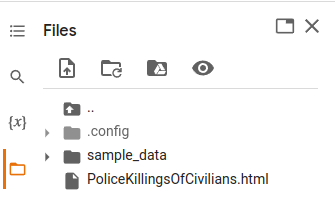

To save the file to your local drive, hover your cursor over the file and select "Download." This will download the file to your local hard-drive's default download folder.

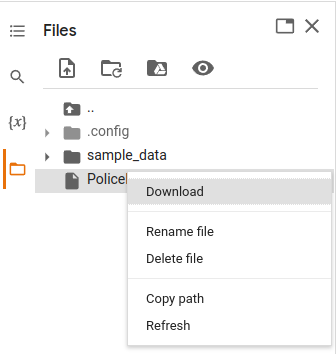

Because Folium saves the maps as HTML documents, they can be added to websites or shared with other people, who can open them with a web-brower.


## Conclusion
Choloropleth maps are an excellent tool for discovering patterns in data that might be otherwise hard to discern.

They have myrid uses: I've used them to examine how the Payroll Protection Act funds were allocated to religious groups by Congressional dictrict and by county. I discovered that the regions that benefited disproportinately were often those represented by politicians who typically decry "government handouts." Lower income counties also benefitted far more than higher income counties.

I've also used Folium to examine where bicycle accidents are reported in Chicago, mapping locations (what streets / intersections are most dangerous) and creating cholorpleth maps of the number of accidents in different city council wards and police precincts.

In short, Folium is an incredibly useful tool for mapping and visualizing data.

## Appendix
The following discussion isn't really about how to use Folium to draw maps. Rather, it is about how to create useful or meaningful maps and how we need to process data to achieve this goal.

### Normalizing Population Data
One issue with choropleth maps that display data about people is that this data tends to correlate closely with population centers. For example: during the Covid-19 pandemic, there were MANY more cases in Cook County, IL with a population of over 5 million, than in Hardin County, IL (pop. 3,900).

The same issue would be arise if we were mapping ocurrences of swine flu (correlated with hog farms), corn leaf blight (correlated with regions that grow corn), etc.

This is why choropleth maps often do not chart raw numbers (as we did above). It is often more appropriate to consider the number of cases per 100,000 population.

To do this, we need to get a dataset that includes county-by-county population statistics that, ideally, include a FIPS code.



I found this data at the [US Census Bureau](https://www.census.gov/), which has a huge number of [datasets](https://www.census.gov/data/datasets.html) that it provides the public.

The full dataset is huge, but when I read the [documentation](https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/co-est2019-alldata.pdf), I realized I only needed three columns: `STATE`,`COUNTY`, and `POPESTIMATE2019`. (I selected 2019 because the *Post*'s data extends from 2015 to present; 2019 is roughly in the middle of that time frame).

Rather than loading the full database, Pandas allows me to specify specific columns to include with the `usecols` parameter.

In [ ]:
pop_df = pd.read_csv('https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/co-est2019-alldata.csv',
                         usecols = ['STATE','COUNTY','POPESTIMATE2019'])
pop_df.head()

Annoying -- `utf-8` is the most common encoding (and the default for Pandas when reading CSV files). But there are others. I Googled this and came up with a suggestion for a different encoding. I'll specify it and see if I can get around the error....

In [ ]:
pop_df = pd.read_csv('https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/co-est2019-alldata.csv',
                         usecols = ['STATE','COUNTY','POPESTIMATE2019'],encoding = "ISO-8859-1")
pop_df.head()

In [ ]:
pop_df.info()

In the other DFs, the FIPS is an `object` (=string) datatype. Here, they've been loaded as numbers (`int64`).

So I need
1. to convert them to a string -- with [.astype(str)](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html)
1. add leading zeros -- with .str.[zfill](https://www.geeksforgeeks.org/python-pandas-series-str-zfill/)(2)
1. Combine these two columns into a `FIPS` column

In [ ]:
pop_df['STATE'] = pop_df['STATE'].astype(str).str.zfill(2) # convert to string, and add leading zeros
pop_df['COUNTY'] = pop_df['COUNTY'].astype(str).str.zfill(3)
pop_df['FIPS'] = pop_df['STATE'] + pop_df['COUNTY'] # combine the state and county fields to create a FIPS
pop_df.head()


This table incldues population stats for both entire states and individual counties.

State values can be identified because their county code (the last three digits) are $000$ but the county numbers start at $001$ and continue to cover all the counties in the state.

So the first row reports the total population for state $01$ (Alabama), while the second row reports the population for county $001$ in Alabama.

Since our earlier DFs don't include rows with a FIPS number of $XX000$ when we do a join/merge, the state figures will be ignored.

Let's do the [merge](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.merge.html), then we can calculate a _per capita_ number for police shootings.

In [ ]:
map_df = map_df.merge(pop_df, on = 'FIPS', how = 'left')
map_df.head()

The map_df has all the columns we've added as we've worked through this notebook. We could tidy it up by deleting them, but there isn't a pressing reason to do so -- it's a relatively small DF (with around 3,100 rows).

For now, let's just add new column that calculates the number of police killings per 100K population.

In [ ]:
map_df['count_per_100K'] = map_df['count'] / (map_df['POPESTIMATE2019']/100000)
map_df.head()

Now, let's try mapping the data per 100K and how this affect the way the map looks.

In [ ]:
m = initMap()

cp = folium.Choropleth(
        geo_data = counties,
        data = map_df,
        columns = ['FIPS','count_per_100K'],
        key_on = 'feature.properties.FIPS',
        bins = 9,
        fill_color='OrRd',
        fill_opacity=0.8,
        line_opacity=0.2,
        nan_fill_color = 'grey',
        legend_name='Number of Fatal Police Shootings (2015-present) (per 100K population)'
        ).add_to(m)

m

Suddenly, high population counties (like Los Angeles and Cook) don't look so bad. Instead, low population counties with a single shooting are highlighted.

We saw that the distribution of `count` was wildly non-normal. Is the `count_per_100K` any better?

In [ ]:
map_df['count_per_100K'].describe()

In [ ]:
map_df.boxplot(column=['count_per_100K'],vert=False)

Good gravy! There are a LOT of outliers. Since this is a VERY uneven distribution, let's try using a log scale again.


In [ ]:
map_df['MapScale'] = np.log10(map_df['count_per_100K'])
map_df.boxplot(column=['MapScale'],vert=False)

With *this* distribution, using the log10 scale converts it to a far more normal distribution.

We will recycle the code from above to plot draw this data with a log scale, with the scale converted back to original values.

We showed how to use the Tooltip function to show some data -- but we can use it to display any of the data in the map_df.

Finally, we'll add a title and the mini-map, too.

In [ ]:
m = initMap()

titleText = """Number of people killed by police in each county (per 100K pop)"""
title_html = '''
             <h4 align="center" style="font-size:16px"><b>{}</b></h4>
             '''.format(titleText)
m.get_root().html.add_child(folium.Element(title_html))

cp = folium.Choropleth(
        geo_data = counties,
        data = map_df,
        columns = ['FIPS','MapScale'],
        key_on = 'feature.properties.FIPS',
        bins = 9,
        fill_color='OrRd',
        fill_opacity=0.8,
        line_opacity=0.2,
        nan_fill_color = 'grey',
        legend_name='Number of Fatal Police Shootings per 100K population (2015-present)'
        ).add_to(m)

map_data_lookup = map_df.set_index('FIPS')

for row in cp.geojson.data['features']:
  try:
      row['properties']['count'] = f"{(map_data_lookup.loc[row['properties']['FIPS'],'count']):.0f}"
  except KeyError:
      row['properties']['count'] = 'No police killings reported'
  try:
      row['properties']['count_per_100K'] = f"{map_data_lookup.loc[row['properties']['FIPS'],'count_per_100K']:.2f}"
  except KeyError:
      row['properties']['count_per_100K'] = 'No data'
  try:
      row['properties']['population'] = f"{map_data_lookup.loc[row['properties']['FIPS'],'POPESTIMATE2019']:,.0f}"
  except KeyError:
      row['properties']['population'] = 'No data'

folium.GeoJsonTooltip(['NAME','population','count','count_per_100K'],
                      aliases=['county:','population:','count:','per100K:']
                      ).add_to(cp.geojson)

from branca.element import Element
e = Element("""
  var ticks = document.querySelectorAll('div.legend g.tick text')
  for(var i = 0; i < ticks.length; i++) {
    var value = parseFloat(ticks[i].textContent.replace(',', ''))
    var newvalue = Math.pow(10.0, value).toFixed(1).toString()
    ticks[i].textContent = newvalue
  }
""")
colormap = cp.color_scale # this finds the color scale in the cp variable
html = colormap.get_root()
html.script.get_root().render()
html.script.add_child(e)

from folium import plugins
minimap = plugins.MiniMap()
m.add_child(minimap)

m

In [ ]:
m.save('Map11.html')

When we look at the number of police killings per 100K population, the map shifts considerably.

The earlier visualizations seemed to suggest the problem was mainly one of large cities, which have (by far) the largest number of incidents of police killing civilians.

A per-capita visualization shows that police are killing civilians across the country.

In fact, the highest rates are in low population counties. For a county like De Baca, NM (population 1,748) one police killing of a civilian means that it has a per100K rate of 57!

This visualization complicates discussions about how to deal with the problem of police killing civilians:
* One could argue that, in a nation awash with guns, an occasional police killing a civilian is inevitable. Perhaps we shouldn't prioritize counties like De Baca (with one death), even if it has *very* high killing-per-100K value.
* Instead of worrying about the killings-per-100K population, we should focus on counties with many cases of police killing civilians, like Los Angeles, where 317 people have been killed.
* But LA's killing-per-100K value is "only" 3.01. Since there are over 10M people in LA county, everything related to people (the number of cars, number of restaurants, cases of flu, etc) will be high. So perhaps we should focus on counties with high killing-per-100K values?

I certainly don't have an answer to this problem, but this analysis shows that the problem is more complex than it is often described in media reports. 

# Your turn

In the next cells
1. I've created a new DF with data about homicides in Chicago, and
1. I've created a new map initialization function, focused on Chicago.

Create a cholorpleth map that shows where homicides have taken place. What region should we use (above, we used county boundaries)? We could use wards (there are 50 wards in Chicago) or police beats (there are 295 beats). Since there are almost six times as many beats, we will use them, so we can get a more precise idea of where homicides have taken place. 


In [3]:
homicides = homicides = pd.read_csv('https://raw.githubusercontent.com/adamlporter/DataAnalysisClass/master/Homicides_20240412.csv')
homicides['dt'] = pd.to_datetime(homicides['Date'],format="%m/%d/%Y %I:%M:%S %p" ) # add column as datetime format


In [4]:
def initChiMap():
    attr = '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors'
    tiles = 'https://tile.openstreetmap.org/{z}/{x}/{y}.png'
    
    map = folium.Map(location=[41.8,-87.6], # roughly the center of Chicago
               zoom_start = 10,
               attr=attr,
               tiles=tiles)
    return map

In [13]:
homicides.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location', 'dt'],
      dtype='object')

In [14]:
len(homicides['Beat'].unique())

295

In [9]:
homicides['Location Description'].value_counts()[:15]

STREET           6618
AUTO             1373
APARTMENT        1123
ALLEY             826
HOUSE             671
PORCH             397
YARD              310
PARKING LOT       260
PARK PROPERTY     142
VACANT LOT        133
HALLWAY           105
RETAIL STORE      101
GAS STATION        84
GANGWAY            74
GARAGE             72
Name: Location Description, dtype: int64